# Studying Zero-inflation in Counts of Medical and Fire Incidents ###

The goal of this notebook is to perform predictive analysis of the number of medical and fire incidents expected in a given area of a fire department's jurisdiction. The predictors are demographic and geographic variables. This type of analysis enables fire departments to make informed decisions about the distribution of resources. 

## Zero-Inflation in modeling incident counts ###

The analysis is typically conducted at the census tract or census block level: the number of incidents in, for example, a census block, is the target variable, while the demographic and geographic characteristics of that block are the predictors. Zero-inflation arises because often splitting the jurisdiction into census blocks results in several blocks having 0 incidents. 

Count data can be modeled with Generalized Linear Model approaches, such as Poisson regression. Zero-inflation is introduced in GLM Poisson regression by assuming that, in addition to the regular Poisson process generating the counts, there is a second process that generates an excess of zero counts, with probability $Q_{0}$. The total probability of observing zero counts is then:


$$P_0^{tot} = Q_0 + (1 - Q_0)\cdot P(k=0)$$

where $P(k)$ is the usual Poisson probability of observing $k$ counts, given a mean of $\lambda$ counts: $\frac{\lambda^k\exp(-\lambda)}{k!}$.

Both $P$ and $Q_0$ are modeled in terms of the predictors. 

## Analysis ###
This notebook uses Python to analyze the count of incidents in the city of Columbus. The effect of zero inflation is explored by comparing a standard Poisson regression with a Zero-Inflated Poisson (ZIP) model.

We start by importing some common libraries for data handling, statistics, and visualization.

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from patsy import dmatrices
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
# random seed for reproducibility
np.random.seed(123456789)


#### Getting the Data ####

Data are contained in two different tables, one with incident counts, and the other with demographic variables. In this case, we are focusing on medical emergencies only. One table provides the census tract ID and the number of incidents in that census tract. The other, the demographic variables for each census tract. Counts data were collected by the Columbus Fire Department. Demographic data were provided by the U.S. Census and the American Community Survey. 

In [53]:
incidents_df = pd.read_csv('Columbus_tracts_counts.csv')
demographic_df = pd.read_csv('Columbus_Demos.csv')

In [54]:
incidents_df.head()

,Point_Coun,Tract_Index
0,1501,1
1,3298,2
2,2033,3
3,715,4
4,485,5


In [55]:
demographic_df.head()

,AGE_UNDER5,AGE_85_UP,VACANT,householdi,disability,educationa,businesses,employment,daytimepop,households,crime_crmc,SOURCE_ID
0,202,58,97,34467.0,364.0,75.0,87.0,16.7,2903.0,1424.0,77.0,1
1,254,13,222,12880.0,345.0,59.0,26.0,16.1,2513.0,529.0,147.0,2
2,223,42,135,22958.0,354.0,122.0,18.0,15.9,2305.0,948.0,84.0,3
3,180,8,86,40611.0,117.0,9.0,205.0,13.5,4333.0,1127.0,160.0,4
4,617,24,118,32732.0,382.0,69.0,29.0,13.3,4213.0,2171.0,45.0,5


"SOURCE_ID" in the demographic dataframe and "Tract_Index" in the incidents dataframe are the columns that identify the census tract. We have to join these tables:

In [56]:
joined_df = incidents_df.merge(demographic_df,left_on='Tract_Index',right_on='SOURCE_ID', how='left')

In [57]:
joined_df.head()

,Point_Coun,Tract_Index,AGE_UNDER5,AGE_85_UP,VACANT,householdi,disability,educationa,businesses,employment,daytimepop,households,crime_crmc,SOURCE_ID
0,1501,1,202,58,97,34467.0,364.0,75.0,87.0,16.7,2903.0,1424.0,77.0,1
1,3298,2,254,13,222,12880.0,345.0,59.0,26.0,16.1,2513.0,529.0,147.0,2
2,2033,3,223,42,135,22958.0,354.0,122.0,18.0,15.9,2305.0,948.0,84.0,3
3,715,4,180,8,86,40611.0,117.0,9.0,205.0,13.5,4333.0,1127.0,160.0,4
4,485,5,617,24,118,32732.0,382.0,69.0,29.0,13.3,4213.0,2171.0,45.0,5


#### Preparing features and target variable ####

For every census tract, the available features are:

- **AGE_UNDER5**: number of people younger than 5
- **AGE_85_UP**: number of people older than 85
- **VACANT**: number of vacant buildings
- **householdi**: average household income
- **disability**: number of people living with a disability
- **educationa**: educational attainment (expressed as the number of people with education level lower than 9th grade)
- **businesses**: number of businesses
- **employment**: unemployment rate
- **daytimepop**: daytime population
- **households**: number of households
- **crime_crmc**: crime rate

We are going to separate features and target variables (the number of incidents, given by the **Point_Coun** column):

In [58]:
features_cols = ['AGE_UNDER5', 'AGE_85_UP',
       'VACANT', 'householdi', 'disability', 'educationa', 'businesses',
       'employment', 'daytimepop', 'households', 'crime_crmc']

In [59]:
features = joined_df[features_cols]
counts = joined_df.Point_Coun

Now create train and test samples:

In [60]:
X_train, X_test, y_train, y_test = train_test_split(features, counts, test_size=0.3)

Looking at the table above, we can see that the features have vastly different numerical ranges. It is important to scale the features. We can use sklearn Standard Scaler:

In [61]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_std,columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_std,columns=X_test.columns)

## Model Fitting ##

### Poisson Regression ###

We will start with a standard **Poisson regression**, with no Zero-Inflation. The count of incidents is assumed to come from a Poisson distribution $\frac{\lambda^k\exp(-\lambda)}{k!}$, where the expected value is dependent on the features ($\bar{x}$): $\log \lambda = \alpha + \bar{\beta}\cdot\bar{x}$, with $\alpha$ and $\beta$ being the coefficients of the regression.

In [62]:
from sklearn.linear_model import PoissonRegressor

reg = PoissonRegressor(max_iter=1000).fit(X_train_scaled_df, y_train.values)

After fitting the model we can calculated predicted counts for the target sample:

In [63]:
poisson_predictions = reg.predict(X_test_scaled_df)

We will look at a quantitative evaluation of the model below in this notebook. For now, let's look at a few predicted values, side by side with the expected test values.

In [75]:
pd.DataFrame({'prediction':poisson_predictions,'test target':y_test}).reset_index(drop=True).head(10)

,prediction,test target
0,445.044226,253
1,593.202677,445
2,4010.133105,3893
3,1166.782624,2048
4,879.211667,1118
5,251.154807,2
6,4579.252527,4520
7,1535.975654,3505
8,471.241623,0
9,1750.461313,2384


While some predicted values are close to the test target value, we can also observe significant differences. For example, for entry 8, we have a census tract with 0 incidents reported, while the model predicts 471 incidents.  

### ZIP Rregression ###

We will implement a ZIP regression, to see if this can help us improve the performance of the model, in particular for cases with 0 counts.  

ZIP regression is available under the statsmodels module. This requires some work to write the model as an expression. We use the patsy library to help format the data:

In [76]:
# concatenate train features and counts
df_train = pd.concat([X_train_scaled_df.reset_index(drop=True),y_train.reset_index(drop=True)],axis=1)
# concatenate test features and counts
df_test = pd.concat([X_test_scaled_df.reset_index(drop=True),y_test.reset_index(drop=True)],axis=1)
# create the model expression: we need to join the features column names and, after that, 
#add the target variable name at the beginning, followed by ~
model_expression = [c+' + ' for c in df_train.columns[:-1]]
model_expression = 'Point_Coun ~ ' + ''.join(model_expression)[:-3]

# now create dataframes for the train and test samples
dy_test, dX_test = dmatrices(model_expression, df_test, return_type='dataframe')
dy_train, dX_train = dmatrices(model_expression, df_train, return_type='dataframe')

In [77]:
# check the model expression
model_expression

'Point_Coun ~ AGE_UNDER5 + AGE_85_UP + VACANT + householdi + disability + educationa + businesses + employment + daytimepop + households + crime_crmc'

We can finally fit a ZIP model:

In [78]:
zip_training_results = sm.ZeroInflatedPoisson(endog=dy_train, exog=dX_train, exog_infl=dX_train, inflation='logit').fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 175.635325
         Iterations: 60
         Function evaluations: 70
         Gradient evaluations: 70


Like before, we can predict the values for the test sample:

In [79]:
zip_predictions = zip_training_results.predict(dX_test,exog_infl=dX_test)

Let's now compare the first few values like we did before

In [83]:
pd.DataFrame({'Poisson predictions':poisson_predictions,'ZIP predictions':zip_predictions.values,'test target':y_test}).reset_index(drop=True).head(10)

,Poisson predictions,ZIP predictions,test target
0,445.044226,508.334443,253
1,593.202677,607.215708,445
2,4010.133105,3835.340622,3893
3,1166.782624,1240.293601,2048
4,879.211667,943.753095,1118
5,251.154807,137.758067,2
6,4579.252527,5883.513340,4520
7,1535.975654,1519.824637,3505
8,471.241623,0.000000,0
9,1750.461313,1878.436596,2384


### Model Comparison ###

We can see that most of the ZIP predicted values are similar to those of the Poisson model. However, the ZIP model does a better job for census tracts with 0 counts: for example, for entry 8, the ZIP model predicts 0 incidents, instead of the 471 predicted by the Poisson model.

We can further investigate the difference by plotting a histogram of the counts of the test values, Poisson predictions, and ZIP predictions. Note that this is plotted as a distribution.

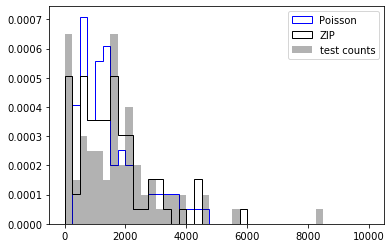

In [86]:
maxr=10000
bs=40
plt.hist(p,bins=bs,range=[0,maxr],histtype=u'step',color='b',density=True,label='Poisson')
plt.hist(zip_predictions.values,range=[0,maxr],bins=bs,color='k',histtype=u'step',density=True,label='ZIP')
plt.hist(y_test.values,range=[0,maxr],bins=bs,color='k',histtype=u'barstacked',density=True,alpha=0.3,label='test counts')
plt.legend()
plt.show()

The figure shows that the ZIP model is much more successfull in modeling the 0 counts, as expected. It also performs better than the Poisson model in the range 0 - 2000. To quantify the improvment we can calculate the RMSE:

In [89]:
def rmse(theory, model):
    return np.sqrt(np.sum(np.power(np.subtract(model,theory),2)))

In [92]:
print('Poisson RMSE:',rmse(y_test,poisson_predictions))
print('ZIP RMSE:',rmse(y_test,zip_predictions))      

Poisson RMSE: 82221.9261103447
ZIP RMSE: 14955.06639175858


Another metric often used with GLM regressions is the pseudo R-squared, which measures how well the model performs compared to an intercept-only model. The sklearn and statsmodel libraries provide the McFadden's version: $$R^2 = 1 - \frac{\log \ell_{Model}}{\log \ell_{Intercept}}$$

Where $\ell_{Model}$ and $\ell_{Intercep}$ are the likelihoods for the fitted and the intercept-only models respectively.

Let's print the pseudo R-squared values for the two models:

In [118]:
print('Poisson pseudo R-sq:',reg.score(X_train_scaled_df,y_train))
print('ZIP RMSE:',zip_training_results.prsquared)

Poisson pseudo R-sq: 0.6258547411773792
ZIP RMSE: 0.639313083290299


### Discussion ###

The pseudo R-suared values are quite similar. The ZIP model offers a slight improvement over the Poisson regression when compared to the incercept-only model. It should be noted that these values are calculated on the train set. This means that both the ZIP and Poisson models can explain the variability of the dataset when compared to an intercept-only model. However, when looking at unseen data (the test set) the RMSE values shown above show a factor $\sim 5$ improvement when using the ZIP model rather than the simple Poisson.   

We can look in particular at the test data that have low incidents counts (or 0 incidents). Here is the comparison: 

In [142]:
# create a dataframe with the test dataset and the predicitons from the two models
df_comparison = pd.DataFrame({'Poisson predictions':poisson_predictions,'ZIP predictions':zip_predictions.values,'test target':y_test}).reset_index(drop=True)
# round to closest integer
for c in df_comparison.columns: df_comparison[c] = df_comparison[c].apply(lambda x: round(x))

In [144]:
# sort by counts in the test data set
df_comparison.sort_values(['test target']).head(40)

,Poisson predictions,ZIP predictions,test target
76,445,0,0
60,359,0,0
58,395,0,0
8,471,0,0
37,515,0,0
5,251,138,2
51,505,0,2
72,325,342,11
26,451,0,39
80,543,0,49


As expected, the ZIP model predictions are more accurate, in particular for census tracts that have a low number of incident counts. 

We conclude that, when planning the distribution of fire departments' resources, it is important to consider the effect of zero-inflated incidents counts. Overpredicting the number of incidents can mislead the distribution of already limited resources, and affect the accuracy of the risk assessment analysis.